In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from scipy.stats import f
from scipy.optimize import curve_fit

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition # For PCA
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import seaborn as sns

from treeExplorer import globalOutlierExplorer

randomState = 42

palette = sns.color_palette("Set2")

params = {'legend.fontsize': 'large',
          'font.family': 'serif',
          'figure.figsize': (13,9),
          'axes.labelsize': 14,
          'axes.titlesize': 18,
          'xtick.labelsize': 14*0.75,
          'ytick.labelsize': 14*0.75}
plt.rcParams.update(params)

## Understanding Dimensionality Reduction for Feature Selection

The problem is that the LZ RQ list used for finding anomalies has several groups of correlated variables. 
This introduces a bias when used in techniques such as the iForest.
The goal is to reduce these correlated groups to singular features representative of the group while retaining enough of the features that contribute to anomalies.

Note that these techniques only *select* RQs from the full set, unlike methods like PCA or tSNE that apply transformations from the higher-D space to a lower one.

The algorithms are presented in https://pureadmin.qub.ac.uk/ws/portalfiles/portal/136557002/fsiv_ieea_final_accepted_paper.pdf and its references.

### Forward Selection Component Analysis (FSCA)

In contrast to taking linear combinations of features to produce principal components that maximize the variance (like PCA), FSCA iteratively maximizes the variance of collections of features, adding another feature at each iteration until the desired number of features is met.

#### FSCA Algorithm

1. Start with the full feature list $X$, and decide the number of features, $K$, to reduce this list to. Create an empty set $Z_0 = \emptyset$ and set $k = 0$.

2. Scale the data to zero mean.

3. Define $Z_{k+1}^\nu$ to be the set $Z_k + \{ x_\nu \}$ where $x_\nu \in X$.

4. Define 

$$ Z_{k+1} = \text{argmin}_\nu  ||X - Z_{k+1}^\nu (Z_{k+1}^{\nu T} Z_{k+1}^\nu)^{-1} Z_{k+1}^{\nu T} X ||$$

5. Update $k$.

6. If $k < K$ go to step 3.

7. Return $Z_K$


In [2]:
def FSCA(data, K, plots = False):
    """Takes in the dataset (2D numpy array) and the number of required features K as input.
       Outputs the subset of feature space it considers most important in reconstructing the full space."""
    
    nRows, nFeatures = np.shape(data)
    
    if K > nFeatures: raise Exception('Requested feature space must be smaller than the full feature space!')
    
    # Empty list of features
    selectedFeatureList = []
    
    # Feature indices
    featureIndices = [*range(nFeatures)]
    
    def frobeniusMatrixNorm(currentFeatures):
        # The matrix Z_{k+1}^{\nu}
        Z = data[:, currentFeatures]
        matrixMultiplicationResult = np.linalg.multi_dot([Z, np.linalg.inv(np.matmul(Z.T, Z)), Z.T, data])
        # Return the Frobenius norm of the matrix
        return np.linalg.norm(data - matrixMultiplicationResult, 'fro')
    
    for k in range(K):
        normList = []
        for nu in featureIndices:
            ZnuIndices = selectedFeatureList + [nu]
            normList.append(frobeniusMatrixNorm(ZnuIndices))

        smallestNormIndex = np.argmin(normList)
        # Add the feature with lowest norm to final feature set and remove it from the starting feature list.
        selectedFeatureList.append( featureIndices.pop(smallestNormIndex) )
    
    return selectedFeatureList

### Forward Selection Independent Variables (FSIV)

Having selected the features that generalize the data best, consider features that are unable to be reconstructed well using the linear approximation. These are important in detecting outliers.

#### FSIV Algorithm

1. Start with the data represented by the full feature space $X$. Decide $k_\text{FSCA}$, the number of features to be selected from FSCA, and $k_\text{FSIV}$, the number of features to be further selected from FSIV. The final number of features will be $K = k_\text{FSCA} + k_\text{FSIV}$.
2. Use the FSCA algorithm to select $k_\text{FSCA}$ features and create the data matrix $Z_0$ with only these features. Set $k=0$.
3. Calculate the linear approximation of the data using $Z_k$:
$$ \hat{X} = Z_k (Z_k^T Z_k)^{-1} Z_k^T X.$$
4. Compute the approximation error for each feature:
$$ \epsilon_i = || x_i - \hat{x}_i ||_2^2 \quad \text{for} \quad x_i \in X \text{ and } \hat{x}_i \in \hat{X}.$$
5. Select the variable with the largest approximation error, $\hat{j} = \text{argmax}_i \epsilon_i$, and add it to $Z_k$.
6. If $k < K$ go to step 3.
7. Return $Z_K$.

In [3]:
def FSIV(data, k1, k2):
    
    currentFeatureList = FSCA(data, k1)
    
    for k in range(k2):
        Z = data[:, currentFeatureList]
        # Compute the linear approximation
        X_hat = np.linalg.multi_dot([Z, np.linalg.inv(np.matmul(Z.T, Z)), Z.T, data])
        errorList = np.linalg.norm(data - X_hat, axis = 0)
        currentFeatureList.append(np.argmax(errorList))
        
    return currentFeatureList

### Forward Selection Minimizing Maximized Reconstruction Error (FSMM)

This is similar to FSIV, but minimizes the largest squared error of the set of features. New features are added to this set over each iteration.

#### FSMM Algorithm

1. Start with the data represented by the full feature space $X$. Decide $k_\text{FSCA}$, the number of features to be selected from FSCA, and $k_\text{FSMM}$, the number of features to be further selected from FSMM. The final number of features will be $K = k_\text{FSCA} + k_\text{FSIV}$.
2. Use the FSCA algorithm to select $k_\text{FSCA}$ features and create the data matrix $Z_0$ with only these features. Set $k=0$.
3. Define $Z^\nu_k = (Z_k, x_\nu)$ where $x_\nu$ is a feature not already selected.
3. Calculate the linear approximation of the data using $Z_k^\nu$:
$$ \hat{X}^\nu = Z^\nu (Z^{\nu T} Z_\nu)^{-1} Z^{\nu T} X.$$
4. Compute the approximation error for each feature:
$$ \hat{\epsilon}_p^\nu = || \hat{x}_p^\nu - x_p^\nu ||_2^2 \quad \text{where $p$ runs over all the features,}$$
and get the largest error (that is, error of a column). Could alternatively take an average?
$$ \hat{\epsilon}^\nu = \text{max}_p \hat{\epsilon}_p^\nu.$$
5. Select the variable with the smallest reconstruction error (the reconstruction error was the max error calculated in the previous step): 
$$\hat{\nu} = \text{argmin}_\nu \hat{\epsilon}^\nu,$$ 
and add it to $Z_k$.
6. If $k < k_\text{FSMM}$ go to step 3.
7. Return $Z_K$.

In [4]:
def FSMM(data, k1, k2):
    
    nRows, nFeatures = np.shape(data)
    
    currentFeatureList = FSCA(data, k1)
    remainingFeatureList = [i for i in range(nFeatures) if i not in currentFeatureList]
    
    for k in range(k2):
        errorList = []
        for nu in remainingFeatureList:
            Znu = data[:, currentFeatureList + [nu]]
            # Compute the linear approximation
            X_hatNu = np.linalg.multi_dot([Znu, np.linalg.inv(np.matmul(Znu.T, Znu)), Znu.T, data])
            # Get the largest reconstruction error (of all the features)
            errorList.append(np.linalg.norm(data - X_hatNu, axis = 0).max())
        currentFeatureList.append( remainingFeatureList.pop(np.argmin(errorList)) )
    
    return currentFeatureList

### Simulating Data for Validation with Paper

Paper: https://pureadmin.qub.ac.uk/ws/portalfiles/portal/136557002/fsiv_ieea_final_accepted_paper.pdf

The paper specified the full feature space $X = (x_1, ..., x_7) \in \mathbb{R}^{1000 \times 7}$ that has three subsets:
1. $X_1 = \{ x_1, x_2, x_3\}$,
2. $X_2 = \{ x_4, x_5, x_6\}$,
3. $X_3 = \{ x_7 \}$.

Correlations between the same subset are $0.9$, between $X_1$ and $X_2$ are $0.4$, between $X_3$ and all other variables are $0.1$.

In [5]:
nEntries = 1000
nFeatures = 7

interSubsetCorrelation = 0.9
interSetCorrelation = 0.4
isolatedCorrelation = 0.1

interSubset = np.full((3,3), fill_value = interSubsetCorrelation)
interSet = np.full((3,3), fill_value = interSetCorrelation)

covarianceMatrix = np.pad( np.block([
                           [interSubset, interSet],
                           [interSet, interSubset]]), 
                   ((0,1), (0,1)), mode = 'constant', constant_values = isolatedCorrelation)
np.fill_diagonal(covarianceMatrix, val = 1)

print("Covariance matrix: \n")
print(covarianceMatrix)

Covariance matrix: 

[[1.  0.9 0.9 0.4 0.4 0.4 0.1]
 [0.9 1.  0.9 0.4 0.4 0.4 0.1]
 [0.9 0.9 1.  0.4 0.4 0.4 0.1]
 [0.4 0.4 0.4 1.  0.9 0.9 0.1]
 [0.4 0.4 0.4 0.9 1.  0.9 0.1]
 [0.4 0.4 0.4 0.9 0.9 1.  0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 1. ]]


The paper uses independent samples from a normal distribution with zero mean and unit STD, transformed with the Cholesky decomposition of the covariance matrix. 

In [6]:
L = np.linalg.cholesky(covarianceMatrix)

# Generate independent normal samples 
np.random.seed(42)
uncorrelatedData = np.random.standard_normal((nEntries, nFeatures))
paperData = np.dot(L, uncorrelatedData.T).T

# Check that the sample generation worked
print("Generated covariance matrix (to check): \n")
print(np.round( np.corrcoef((paperData.T)), 2))

Generated covariance matrix (to check): 

[[1.   0.9  0.9  0.4  0.4  0.4  0.13]
 [0.9  1.   0.9  0.39 0.4  0.39 0.13]
 [0.9  0.9  1.   0.41 0.41 0.4  0.11]
 [0.4  0.39 0.41 1.   0.9  0.91 0.13]
 [0.4  0.4  0.41 0.9  1.   0.89 0.15]
 [0.4  0.39 0.4  0.91 0.89 1.   0.1 ]
 [0.13 0.13 0.11 0.13 0.15 0.1  1.  ]]


One of the entries in $x_7$ is set to $10$.

In [7]:
anomalousPoint = 42
paperData[anomalousPoint, -1] = 10

#### Reducing the data to two components

In [8]:
scaler = StandardScaler()
scaledPaperData = scaler.fit_transform(paperData)

In [9]:
xFSCA, yFSCA = FSCA(scaledPaperData, 2)
xFSIV, yFSIV = FSIV(scaledPaperData, 1, 1)
xFSMM, yFSMM = FSMM(scaledPaperData, 1, 1)

comparisonPCA = decomposition.PCA(n_components = 2, random_state = 42)
xPCA, yPCA = np.hsplit(comparisonPCA.fit_transform(scaledPaperData), 2)

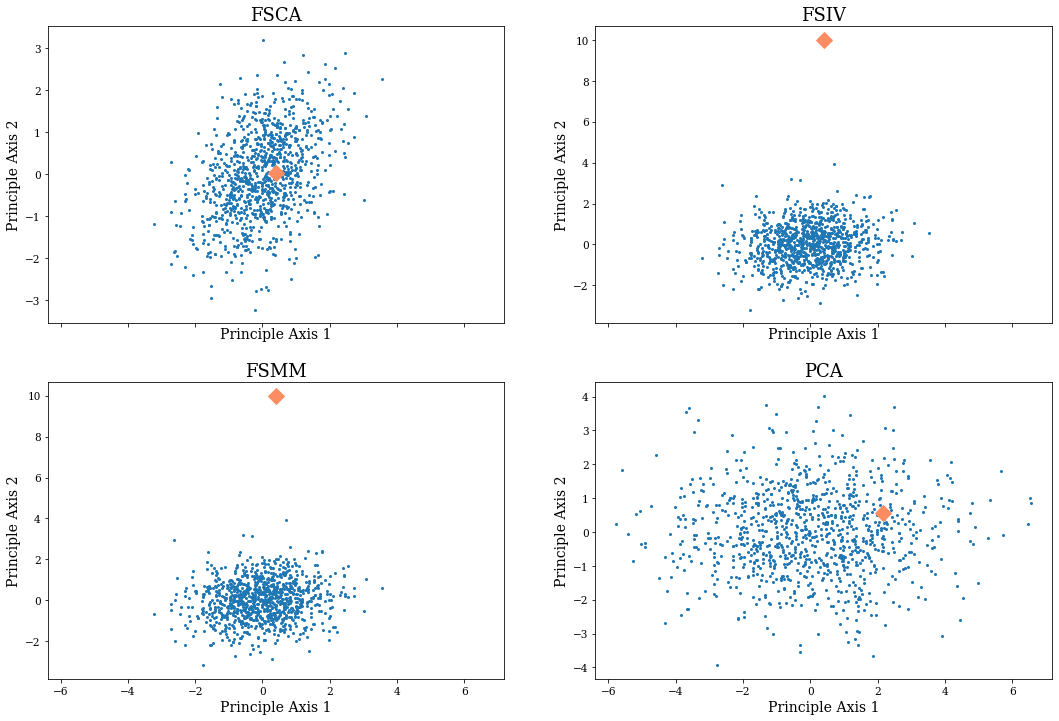

In [10]:
techniques = [(xFSCA, yFSCA, 'FSCA'), (xFSIV, yFSIV, 'FSIV'), (xFSMM, yFSMM, 'FSMM'), (xPCA, yPCA, 'PCA')]

fig, axes = plt.subplots(2, 2, figsize = (18, 12), sharex = True)

for tech, ax in zip(techniques, axes.flatten()):
    if isinstance(tech[0], int):
        ax.plot(paperData[:, tech[0]], paperData[:, tech[1]], 'o', markersize = 2)
        ax.plot(paperData[anomalousPoint, tech[0]], paperData[anomalousPoint, tech[1]], 'D', color = palette[1], markersize = 12)
    else:
        ax.plot(xPCA, yPCA, 'o', markersize = 2)
        ax.plot(xPCA[anomalousPoint], yPCA[anomalousPoint], 'D', color = palette[1], markersize = 12)
    ax.set_xlabel('Principle Axis 1')
    ax.set_ylabel('Principle Axis 2')
    ax.set_title(tech[2])

These distribution agree well with the results from the paper. FSIV and FSMM happen to choose the same variables in this test case, which was also what the paper observed.

### Test with LZ data

In [11]:
cwd = !pwd
dfUnscaled = pd.read_pickle(cwd[0] + "/data/bckgData_SS.pkl")
dfUnscaled

S1c    logS2c          rc2  driftTime  eventID  runID  \
0      484.050446  5.585304   653.898842     447.94  3856795    172   
1      229.025620  5.268730  4048.036364     369.00  3857957    172   
2      441.421692  5.389695   542.451815     368.08  3859004    172   
3       23.904121  4.325637  1855.985102     171.41  3859572    172   
4      200.653870  4.820217   602.539850      88.06  3862253    172   
...           ...       ...          ...        ...      ...    ...   
14593   19.779121  2.483551  1629.111889     367.43  3355366    262   
14594  391.226074  6.183114  4583.575940     459.44  3485646    262   
14595  318.580109  5.233094  3562.160012     334.98  3489371    262   
14596  353.023254  5.286201  2161.272503     160.32  3537626    262   
14597  470.639008  6.192151  4454.456762     232.85  3547263    262   

                                                    file  TBAsymmetry  \
0      /global/projecta/projectdirs/lz/data/warehouse...    -0.503264   
1      /global/projecta/projectdirs/lz/data/warehouse...    -0.340579   
2      /global/projecta/projectdirs/lz/data/warehouse...    -0.436119   
3      /global/projecta/projectdirs/lz/data/warehouse...    -0.172046   
4      /global/projecta/projectdirs/lz/data/warehouse...    -0.030354   
...                                                  ...          ...   
14593  /global/projecta/projectdirs/lz/data/warehouse...     0.447466   
14594  /global/projecta/projectdirs/lz/data/warehouse...    -0.541874   
14595  /global/projecta/projectdirs/lz/data/warehouse...    -0.345984   
14596  /global/projecta/projectdirs/lz/data/warehouse...    -0.116512   
14597  /global/projecta/projectdirs/lz/data/warehouse...    -0.182158   

       peakFractionTop  peakFractionBottom  ...  s1PulseArea1000  \
0             0.034230            0.015756  ...       474.292786   
1             0.041043            0.026177  ...       201.871506   
2             0.023673            0.026668  ...       380.598999   
3             0.210982            0.160266  ...        20.911556   
4             0.043441            0.044332  ...       161.393799   
...                ...                 ...  ...              ...   
14593         0.675896            0.422621  ...        17.289709   
14594         0.052313            0.022953  ...       367.933716   
14595         0.034858            0.021430  ...       281.499207   
14596         0.049355            0.026248  ...       292.626923   
14597         0.025393            0.021816  ...       397.609283   

       s1PulseArea2000  s1PulseArea5000  s2PulseArea50  s2PulseArea100  \
0           474.292786       474.292786    1590.523438     3346.339844   
1           211.560425       211.560425     600.443359     1256.260742   
2           384.706299       384.706299    1104.937012     2400.697754   
3            20.911556        20.911556     167.935120      364.373474   
4           161.852661       161.852661     803.349121     1738.500244   
...                ...              ...            ...             ...   
14593        17.968800        17.968800       8.211422       14.008974   
14594       371.558075       371.565247    4402.632812     9291.250000   
14595       283.701111       283.673065     892.731445     1843.435547   
14596       299.950165       299.955261    1786.571289     3856.407227   
14597       401.858337       402.388184    7651.816406    16287.597656   

       s2PulseArea200  s2PulseArea500  s2PulseArea1000  s2PulseArea2000  \
0         7342.757812    23872.441406     65960.945312    164339.296875   
1         2840.355469    10361.291016     31338.021484     77296.679688   
2         5409.279785    18554.884766     52741.855469    121924.226562   
3          860.347229     3127.328857      8880.532227     14790.415039   
4         4246.071289    15679.171875     38697.746094     52146.937500   
...               ...             ...              ...              ...   
14593       23.794786       57.854843       110.99612

In [12]:
trainingVariables = ["rc2",
                     "driftTime",
                     "TBAsymmetry",
                     "peakFractionTop", "peakFractionBottom",
                     "clusterSize",
                     "promptFraction",
                     "pulseBeforeS1Size", "pulseBeforeS2Size", "pulseAfterS1Size", "pulseAfterS2Size",
                     "s1AFT10", "s1AFT25", "s1AFT50", "s1AFT75", "s1AFT90", "s1AFT95", "s1AFT99", 
                     "s2AFT10", "s2AFT25", "s2AFT50", "s2AFT75", "s2AFT90", "s2AFT95", "s2AFT99",
                     's1PulseArea50', 's1PulseArea100', 's1PulseArea200', 's1PulseArea500', 's1PulseArea1000',
                     's1PulseArea2000', 's1PulseArea5000', 's2PulseArea50', 's2PulseArea100', 's2PulseArea200',
                     's2PulseArea500', 's2PulseArea1000', 's2PulseArea2000', 's2PulseArea5000'
                     ]
trainingVariablesDict = {i : RQ for i, RQ in enumerate(trainingVariables)}

# The main groups of correlated variables
s1pulseAreaVariables = [var for var in trainingVariables if 's1PulseArea' in var]
s2pulseAreaVariables = [var for var in trainingVariables if 's2PulseArea' in var]
s1AFTs = [var for var in trainingVariables if 's1AFT' in var]
s2AFTs = [var for var in trainingVariables if 's2AFT' in var]

remainingVariables = [var for var in trainingVariables if var not in s1pulseAreaVariables + s2pulseAreaVariables + s1AFTs + s2AFTs]
                      
s1pulseAreaVariablesDict = {i : RQ for i, RQ in enumerate(s1pulseAreaVariables)}
s2pulseAreaVariablesDict = {i : RQ for i, RQ in enumerate(s2pulseAreaVariables)}
s1AFTsDict = {i : RQ for i, RQ in enumerate(s1AFTs)}
s2AFTsDict = {i : RQ for i, RQ in enumerate(s2AFTs)}

#### Reduce the RQ families down to two RQs

One RQ will be selected according to the FSCA algorithm, and the other according to FSMM. 

In [13]:
def selectFamilyVariables(data, variableList):
    indexList = [i for i, var in trainingVariablesDict.items() if var in variableList]
    return data[:, indexList]

In [14]:
dataLZ = scaler.fit_transform(dfUnscaled[trainingVariables])

In [15]:
s1PulseAreaData = selectFamilyVariables(dataLZ, s1pulseAreaVariables)
s2PulseAreaData = selectFamilyVariables(dataLZ, s2pulseAreaVariables)
s1AFTData = selectFamilyVariables(dataLZ, s1AFTs)
s2AFTData = selectFamilyVariables(dataLZ, s2AFTs)

In [16]:
FSMM_s1PulseArea = FSMM(s1PulseAreaData, 1, 1)
FSMM_s2PulseArea = FSMM(s2PulseAreaData, 1, 1)
FSMM_s1AFT = FSMM(s1AFTData, 1, 1)
FSMM_s2AFT = FSMM(s2AFTData, 1, 1)

FSMM_s1PulseAreaNames = [value for key, value in s1pulseAreaVariablesDict.items() if key in FSMM_s1PulseArea]
FSMM_s2PulseAreaNames = [value for key, value in s2pulseAreaVariablesDict.items() if key in FSMM_s2PulseArea]
FSMM_s1AFTNames = [value for key, value in s1AFTsDict.items() if key in FSMM_s1AFT]
FSMM_s2AFTNames = [value for key, value in s2AFTsDict.items() if key in FSMM_s2AFT]

print('FSMM S1 Pulse Area: ')
print(FSMM_s1PulseAreaNames)
print('\nFSMM S2 Pulse Area: ')
print(FSMM_s2PulseAreaNames)
print('\nFSMM S1 AFT: ')
print(FSMM_s1AFTNames)
print('\nFSMM S2 AFT: ')
print(FSMM_s2AFTNames)

FSMM S1 Pulse Area: 
['s1PulseArea50', 's1PulseArea200']

FSMM S2 Pulse Area: 
['s2PulseArea50', 's2PulseArea5000']

FSMM S1 AFT: 
['s1AFT25', 's1AFT75']

FSMM S2 AFT: 
['s2AFT25', 's2AFT50']


#### Visualize correlations

##### Before

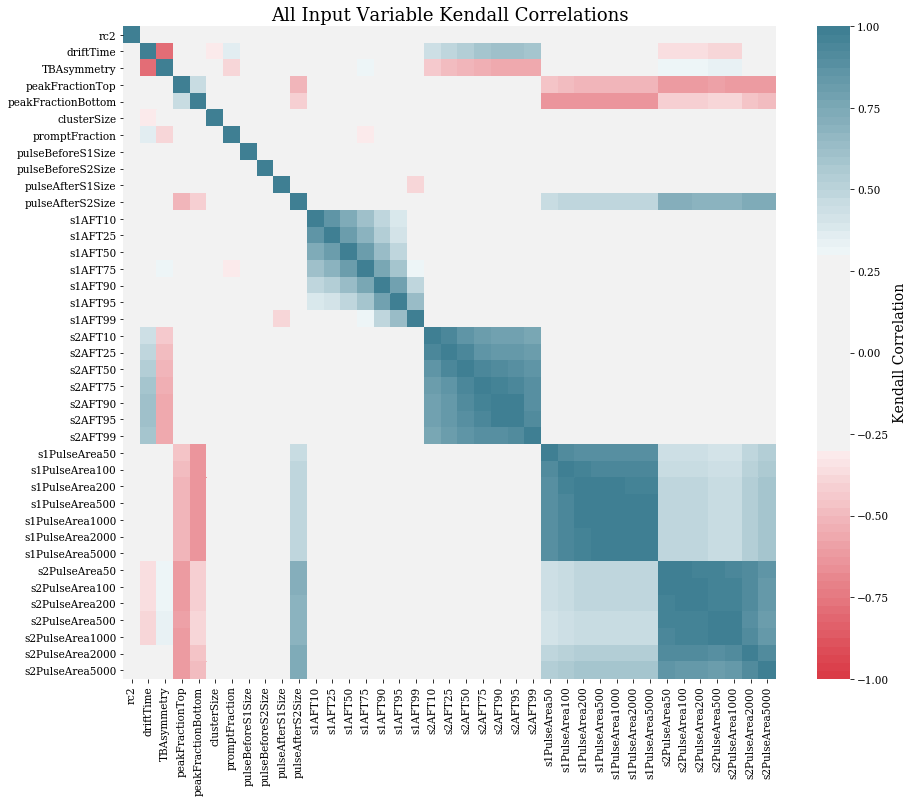

In [17]:
kendallCorr = dfUnscaled[trainingVariables].corr(method = 'kendall')

plt.figure(figsize = (15,12))
sns.heatmap(kendallCorr, vmin = -1, annot = False, fmt = '0.1f', 
            cmap = sns.diverging_palette(10, 220, sep=80, n = 80), 
            square = True, cbar_kws = {'label' : 'Kendall Correlation'})
plt.title('All Input Variable Kendall Correlations')
plt.show()

##### After

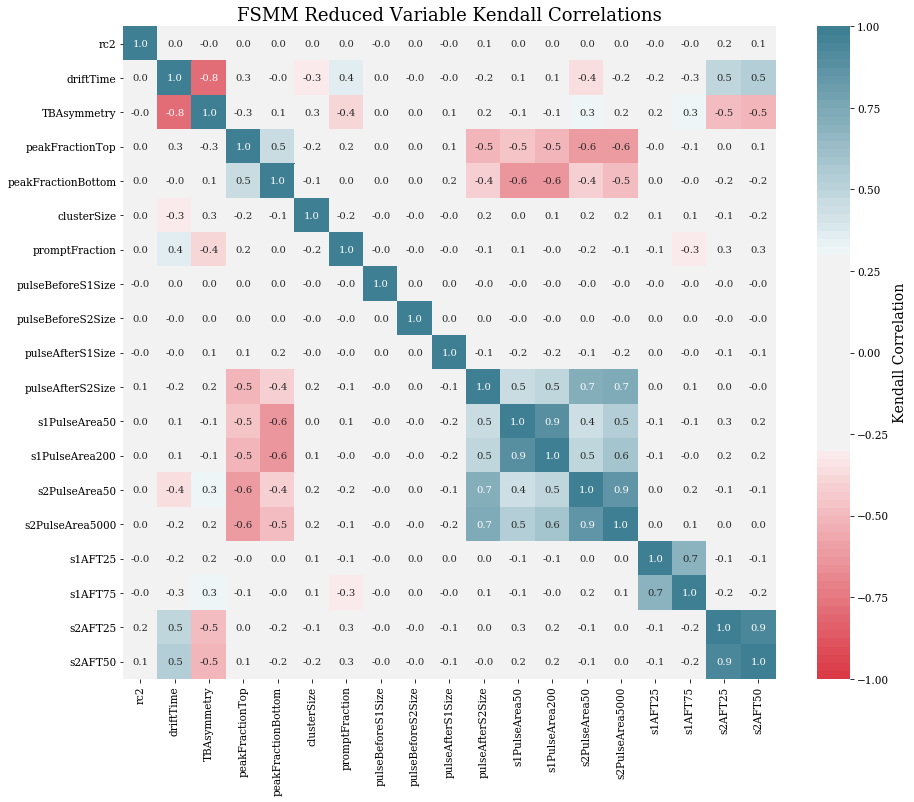

In [18]:
reducedVariables = remainingVariables + FSMM_s1PulseAreaNames + FSMM_s2PulseAreaNames + FSMM_s1AFTNames + FSMM_s2AFTNames
reducedVariablesDict = {i : RQ for i, RQ in enumerate(reducedVariables)}

kendallCorr = dfUnscaled[reducedVariables].corr(method = 'kendall')

plt.figure(figsize = (15,12))
sns.heatmap(kendallCorr, vmin = -1, annot = True, fmt = '0.1f', 
            cmap = sns.diverging_palette(10, 220, sep=80, n = 80), 
            square = True, cbar_kws = {'label' : 'Kendall Correlation'})
plt.title('FSMM Reduced Variable Kendall Correlations')
plt.show()

There are not many groups of correlated features now.
However, we are dropping 7 out of 9 features, and these may contribute to anomalies. 
Thus a balance must be struck here between the amount of correlation acceptable and dropping anomaly-contributing features.

### Training iForests 

#### iForest with all features

In [19]:
%%time
fullIF = IsolationForest(n_estimators = 5000, warm_start = True, verbose = 1, random_state = randomState)
fullIF.fit(dfUnscaled[trainingVariables])
fullIF.set_params(n_estimators = 10_000) # Refit with new trees
fullIF.fit(dfUnscaled[trainingVariables])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 23.9 s, sys: 140 ms, total: 24.1 s
Wall time: 24.1 s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.9s finished


IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=10000,
                n_jobs=None, random_state=42, verbose=1, warm_start=True)

In [20]:
%time fullAnomalyScores = fullIF.decision_function(dfUnscaled[trainingVariables])

CPU times: user 46 s, sys: 48.2 ms, total: 46 s
Wall time: 46 s


#### iForest with FSMM reduced features

In [20]:
%%time
reducedIF = IsolationForest(n_estimators = 5000, warm_start = True, verbose = 1, random_state = randomState)
reducedIF.fit(dfUnscaled[reducedVariables])
reducedIF.set_params(n_estimators = 10_000) # Refit with new trees
reducedIF.fit(dfUnscaled[reducedVariables])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 19.2 s, sys: 116 ms, total: 19.3 s
Wall time: 19.3 s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s finished


IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=10000,
                n_jobs=None, random_state=42, verbose=1, warm_start=True)

In [22]:
%time reducedAnomalyScores = reducedIF.decision_function(dfUnscaled[reducedVariables])

CPU times: user 37.1 s, sys: 84 ms, total: 37.2 s
Wall time: 37.2 s


#### Anomaly Score 

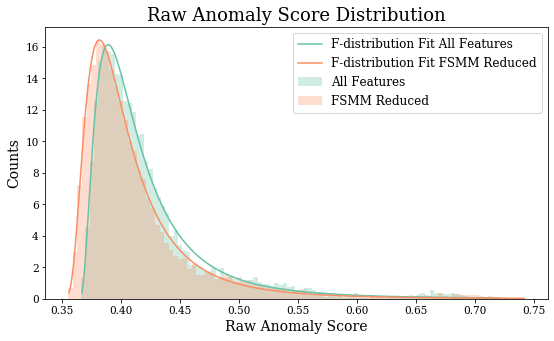

In [23]:
nBins = 300
nBinsHist = 100

plt.figure(figsize = (9, 5))

# Sklearn applies an offset to the raw score
rawFullAnomalyScore = - fullAnomalyScores - fullIF.offset_
counts, binEdges = np.histogram(rawFullAnomalyScore, bins = nBins, density = True)
binCenters = (binEdges + (binEdges[-1] - binEdges[0]) / nBins / 2)[:-1]

plt.hist(rawFullAnomalyScore, bins = nBinsHist, color = palette[0], density = True, alpha = 0.3, label = 'All Features')
fDistributionParams, _ = curve_fit(f.pdf, binCenters, counts, p0 = [10, 2, 0.37, 0.04])
fDistribution = f.pdf(binCenters, *fDistributionParams)
plt.plot(binCenters, fDistribution, color = palette[0], label = 'F-distribution Fit All Features')
percents = f.interval([0.90, 0.95, 0.99], *fDistributionParams)

rawReducedAnomalyScore = - reducedAnomalyScores - fullIF.offset_
counts, binEdges = np.histogram(rawReducedAnomalyScore, bins = nBins, density = True)
binCenters = (binEdges + (binEdges[-1] - binEdges[0]) / nBins / 2)[:-1]

plt.hist(rawReducedAnomalyScore, bins = nBinsHist, color = palette[1], density = True, alpha = 0.3, label = 'FSMM Reduced')
fDistributionParams, _ = curve_fit(f.pdf, binCenters, counts, p0 = [10, 2, 0.37, 0.04])
fDistribution = f.pdf(binCenters, *fDistributionParams)
plt.plot(binCenters, fDistribution, color = palette[1], label = 'F-distribution Fit FSMM Reduced')
percents = f.interval([0.90, 0.95, 0.99], *fDistributionParams)

plt.ylabel('Counts')
plt.xlabel('Raw Anomaly Score')
plt.title('Raw Anomaly Score Distribution')
plt.legend()
plt.show()

#### Taking a look at the anomalies

In [24]:
fullAnomalyThreshold = - 0.045
dfUnscaled['FullAnomalyScore'] = fullAnomalyScores
dfUnscaled['FullOutlier'] = np.where(fullAnomalyScores < fullAnomalyThreshold, True, False)

fullOutlierCounts = dfUnscaled.FullOutlier.value_counts()
fullOutlierCounts

False    13921
True       677
Name: FullOutlier, dtype: int64

In [25]:
reducedAnomalyThreshold = - 0.027
dfUnscaled['ReducedAnomalyScore'] = reducedAnomalyScores
dfUnscaled['ReducedOutlier'] = np.where(reducedAnomalyScores < reducedAnomalyThreshold, True, False)

reducedOutlierCounts = dfUnscaled.ReducedOutlier.value_counts()
reducedOutlierCounts

False    13918
True       680
Name: ReducedOutlier, dtype: int64

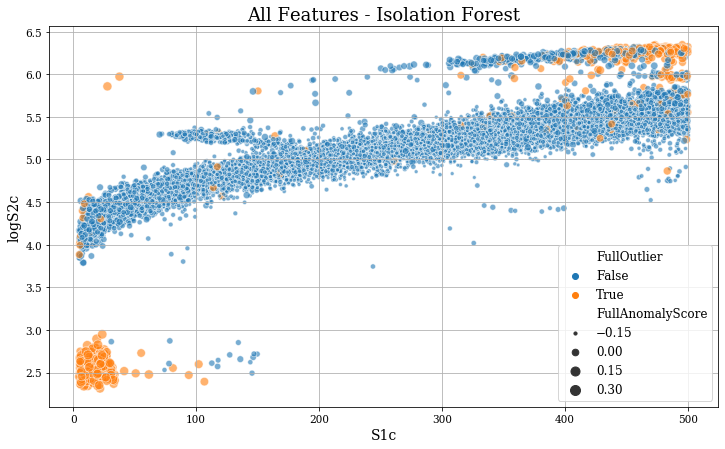

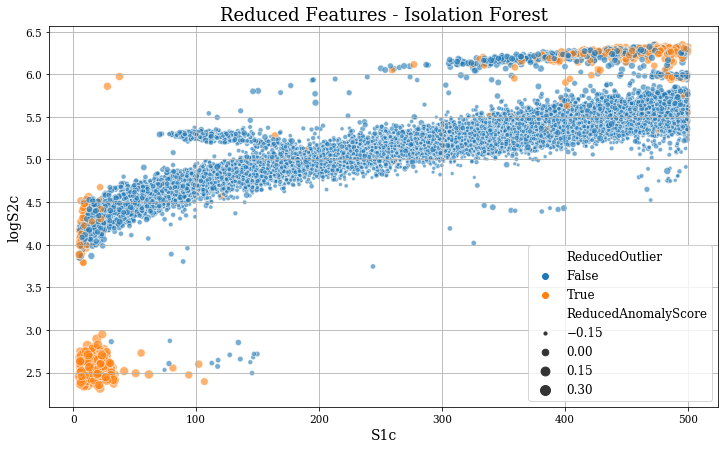

In [26]:
plt.figure(figsize = (12,7))
sns.scatterplot(x = 'S1c',
                y = 'logS2c',
                data = dfUnscaled,
                hue = 'FullOutlier',
                size = - dfUnscaled.FullAnomalyScore,
                sizes = (10, 100),
                alpha = 0.6,
                legend = 'brief')
plt.grid()
plt.title('All Features - Isolation Forest')
plt.show()

plt.figure(figsize = (12,7))
sns.scatterplot(x = 'S1c',
                y = 'logS2c',
                data = dfUnscaled,
                hue = 'ReducedOutlier',
                size = - dfUnscaled.ReducedAnomalyScore,
                sizes = (10, 100),
                alpha = 0.6,
                legend = 'brief')
plt.grid()
plt.title('Reduced Features - Isolation Forest')
plt.show()

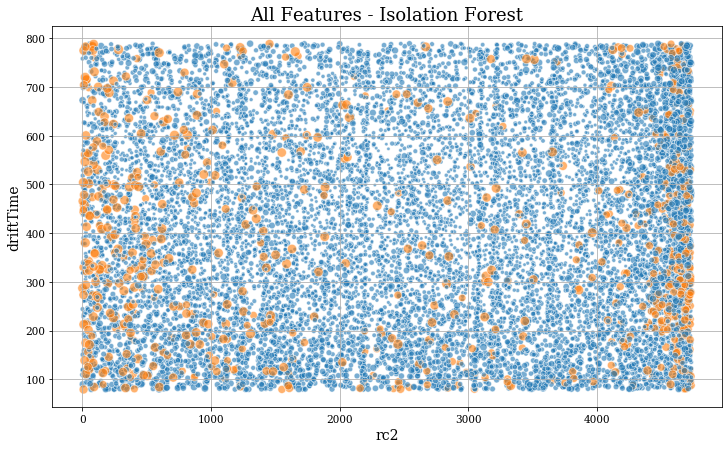

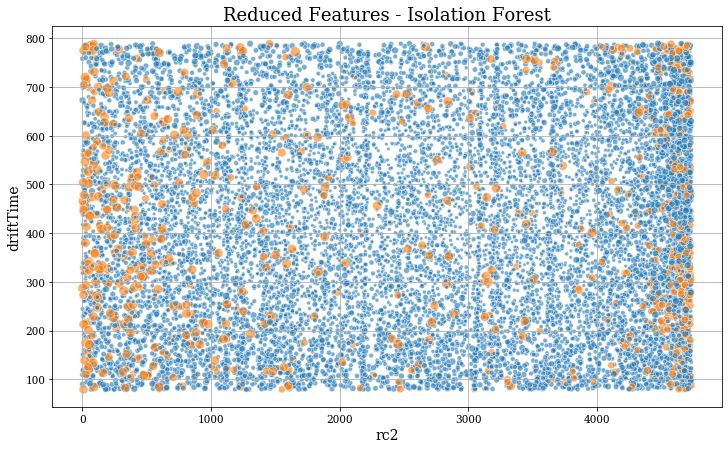

In [27]:
plt.figure(figsize = (12,7))
sns.scatterplot(x = 'rc2',
                y = 'driftTime',
                data = dfUnscaled,
                hue = 'FullOutlier',
                size = - dfUnscaled.FullAnomalyScore,
                sizes = (10, 100),
                alpha = 0.6,
                legend = None)
plt.grid()
plt.title('All Features - Isolation Forest')
plt.show()

plt.figure(figsize = (12,7))
sns.scatterplot(x = 'rc2',
                y = 'driftTime',
                data = dfUnscaled,
                hue = 'ReducedOutlier',
                size = - dfUnscaled.ReducedAnomalyScore,
                sizes = (10, 100),
                alpha = 0.6,
                legend = None)
plt.grid()
plt.title('Reduced Features - Isolation Forest')
plt.show()

In [100]:
%time fullGlobalImportances = globalOutlierExplorer(dfUnscaled[trainingVariables], fullIF, batchSize = 10)

Batch 1 of 200 events processed for 200 random trees in the iForest.
Batch 2 of 200 events processed for 200 random trees in the iForest.
Batch 3 of 200 events processed for 200 random trees in the iForest.
Batch 4 of 200 events processed for 200 random trees in the iForest.
Batch 5 of 200 events processed for 200 random trees in the iForest.
Batch 6 of 200 events processed for 200 random trees in the iForest.
Batch 7 of 200 events processed for 200 random trees in the iForest.
Batch 8 of 200 events processed for 200 random trees in the iForest.
Batch 9 of 200 events processed for 200 random trees in the iForest.
Batch 10 of 200 events processed for 200 random trees in the iForest.
CPU times: user 2min 3s, sys: 287 ms, total: 2min 3s
Wall time: 2min 4s


In [98]:
%time reducedGlobalImportances = globalOutlierExplorer(dfUnscaled[reducedVariables], reducedIF, batchSize = 10)

Batch 1 of 200 events processed for 200 random trees in the iForest.
Batch 2 of 200 events processed for 200 random trees in the iForest.
Batch 3 of 200 events processed for 200 random trees in the iForest.
Batch 4 of 200 events processed for 200 random trees in the iForest.
Batch 5 of 200 events processed for 200 random trees in the iForest.
Batch 6 of 200 events processed for 200 random trees in the iForest.
Batch 7 of 200 events processed for 200 random trees in the iForest.
Batch 8 of 200 events processed for 200 random trees in the iForest.
Batch 9 of 200 events processed for 200 random trees in the iForest.
Batch 10 of 200 events processed for 200 random trees in the iForest.
CPU times: user 3min 11s, sys: 297 ms, total: 3min 11s
Wall time: 3min 12s


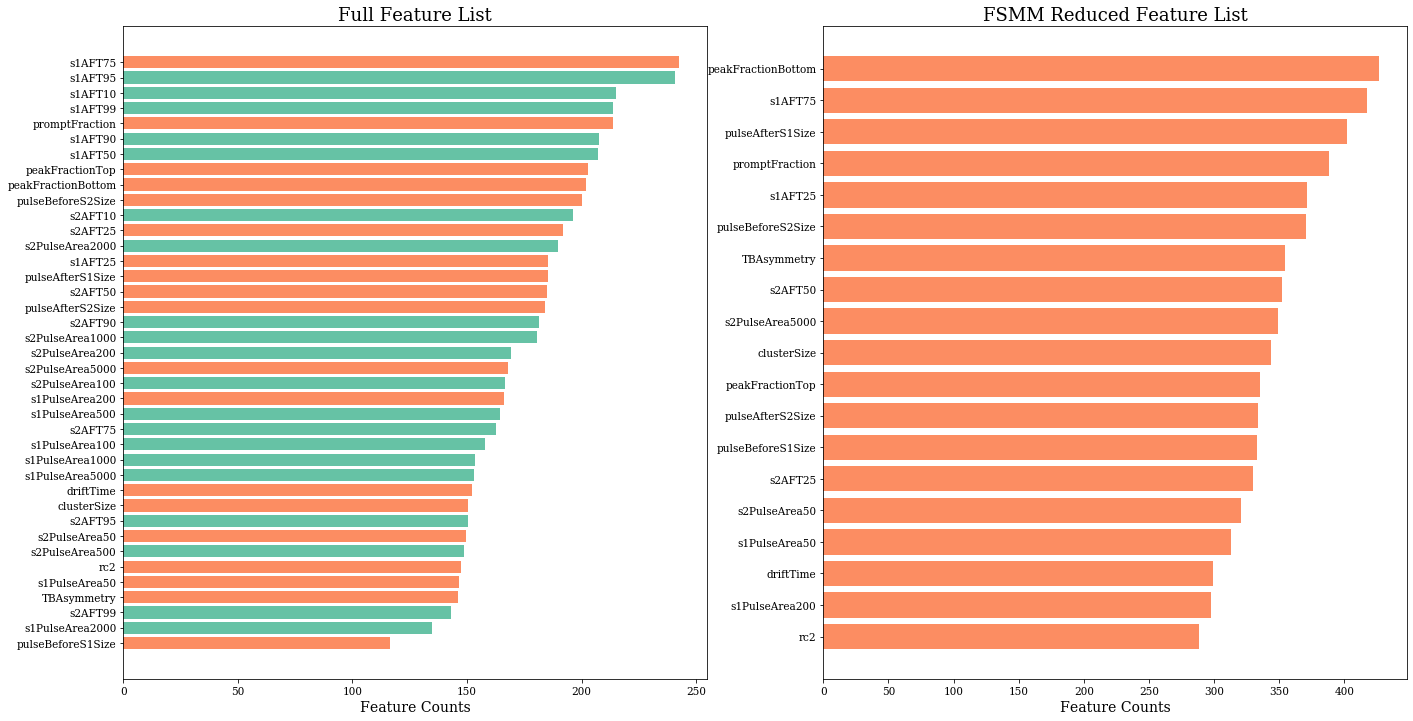

In [108]:
colors = [palette[1] if var in reducedGlobalImportances.keys() else palette[0] for var in fullGlobalImportances.keys()]
fig, axes = plt.subplots(1, 2, figsize = (23, 12))
axes[0].barh(list(fullGlobalImportances.keys()), fullGlobalImportances.values(), color = colors)
axes[0].set_xlabel('Feature Counts')
axes[0].set_title("Full Feature List")

axes[1].barh(list(reducedGlobalImportances.keys()), reducedGlobalImportances.values(), color = palette[1])
axes[1].set_xlabel('Feature Counts')
axes[1].set_title("FSMM Reduced Feature List")

plt.show()

In [109]:
def globalOutlierExplorer(dataFrame, 
                          model,
                          batchSize = 3, 
                          pathLengthThreshold = 4, 
                          subSampleSize = 200, 
                          treeSampleSize = 200, 
                          cutWeight = 0.5):
    """This function takes a dataframe, a maximum path length of an event through a tree in the forest, 
       a sampling size to use on the dataframe, and a geometric cut weight to assign to each depth.
       It returns a dictionary of feature importances."""
    
    # Create a dictionary with the column names
    columnsDict = {i: RQ for i, RQ in enumerate(dataFrame.columns.to_list())}

    # Create a list to append first, second, ... cuts
    orderedCutFrequency = []
    
    numEntries = dataFrame.shape[0]
    
    if treeSampleSize > len(model):
        raise Exception("Tree sample size greater than number of trees in iForest!")

    if subSampleSize > numEntries:
        raise Exception("Subsampling size greater than number of entries in dataframe!")
    
    for batch in range(batchSize):
        
        # Sample from the full input data; else it'll just take too long
        samples = dataFrame.to_numpy(dtype = float)[np.random.randint(len(dataFrame), size = subSampleSize)]
        
        # Loop through each sample
        for sample in samples:

            # For each sample, select a random set of trees in the iForest
            randomTrees = random.choices(model, k = treeSampleSize)
            pathLengths = np.zeros(treeSampleSize)

            # Loop through the trees in the iForest
            for treeIndex, treeIF in enumerate(randomTrees):

                nodeFeatures = treeIF.tree_.feature
                nodeThresholds = treeIF.tree_.threshold

                nodeIndicator = treeIF.decision_path([sample])

                # Index of the leaf that the sample ended up in
                leafID = treeIF.apply([sample])[0]

                pathLengths[treeIndex] = np.size(nodeIndicator)

                # Consider only short paths (these are more likely to have outliers)
                if pathLengths[treeIndex] <= pathLengthThreshold:

                    # Get the node indices of the decision path
                    nodeIndex = nodeIndicator.indices[nodeIndicator.indptr[0]: 
                                                      nodeIndicator.indptr[1]]

                    for i, nodeID in enumerate(nodeIndex):

                        # Terminate if already at the leaf node
                        if leafID == nodeID:
                            continue

                        # Add the feature that was cut and the depth at which it was cut
                        orderedCutFrequency.append([columnsDict.get(nodeFeatures[nodeID]), i+1])
        
        print('Batch %s of %s events processed for %s random trees in the iForest.' % (batch+1, subSampleSize, treeSampleSize))

    orderedCutFrequencyDF = pd.DataFrame(orderedCutFrequency, columns = ['Feature', 'CutNumber'])
 
    # Weigh the features
    featureCountsDict = {RQ : 0 for RQ in columnsDict.values()}
    for RQ, cutNum in orderedCutFrequency:
        featureCountsDict[RQ] += 1 * pow(cutWeight, cutNum - 1)
    
    # Sort the features by importance
    featureCountsDict = {k: v for k, v in sorted(featureCountsDict.items(), key = lambda item: item[1])}
    
    return featureCountsDict